In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/29 18:28:04 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/09/29 18:28:05 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_9399/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Pandas

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
# import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### df Spark

In [6]:
# read traffic data:

table_name = 'beemetrics.DM_MOBILE_SUBSCRIBER_USAGE_DAILY'

start_date = datetime.date(2025, 6, 1) # -- !!!
end_date = datetime.date(2025, 9, 22) # -- !!!

df = (
   spark.read.table(table_name)
    .where(F.col('transaction_dt') >= start_date)
    .where(F.col('transaction_dt') <  end_date)
    .where(F.col('business_type_cd') == 'B2B')
    .where(~F.col('segment_cd').isin('GKA', 'GME', 'GLA', 'GSE', 'GSH'))
    # .where(F.col('subs_market_cd') == 'VIP')      # --!!!!
    # .where(F.col('account_type_cd').isin(['47', '120']))  # -- MK
    .groupby(
        F.col('transaction_dt'),
        F.col('subscriber_sk'),
        F.col('subscriber_num'),
        F.col('ban_num'),
        F.col('price_plan_cd'),
        F.col('segment_cd'),
        F.col('subs_market_cd'),
        # F.col('call_direction_cd'),
        # F.col('roaming_cd')
    )
    .agg(
        F.sum(F.when( (F.col('activity_cd') == 'VOICE') & (F.col('call_direction_cd') == 1) & (F.col('roaming_cd') == 'H'), F.col('usage_amt')/60 )).alias('voice_min_1_H'),
        F.sum(F.when( (F.col('activity_cd') == 'VOICE') & (F.col('call_direction_cd') == 2) & (F.col('roaming_cd') == 'H'), F.col('usage_amt')/60 )).alias('voice_min_2_H'),
        F.sum(F.when( (F.col('activity_cd') == 'VOICE') & (F.col('call_direction_cd') == 1) & (F.col('roaming_cd') != 'H'), F.col('usage_amt')/60 )).alias('voice_min_1_R'),
        F.sum(F.when( (F.col('activity_cd') == 'VOICE') & (F.col('call_direction_cd') == 2) & (F.col('roaming_cd') != 'H'), F.col('usage_amt')/60 )).alias('voice_min_2_R'),
        #F.sum(expr("case when activity_cd = 'VOICE' then usage_amt end "))
        #F.sum(F.when(F.col('activity_cd').isin( ['VOICE_TO_MCC', 'VOICE_MAIL']), F.col('usage_amt')/60)).alias('voice_2_min'),
        F.sum(F.when( (F.col('activity_cd') == 'GPRS') & (F.col('call_direction_cd') == 3) & (F.col('roaming_cd') == 'H'), F.col('usage_amt')/1024/1024)).alias('gprs_mb_3_H'),
        F.sum(F.when( (F.col('activity_cd') == 'GPRS') & (F.col('call_direction_cd') == 3) & (F.col('roaming_cd') != 'H'), F.col('usage_amt')/1024/1024)).alias('gprs_mb_3_R')
    )
    # .join(df_target_sp_CORE, how = 'left', on = 'subscriber_sk')
)

print('num_rows:', df.count())  
# print('num_cols:', len(df.columns))  
df.printSchema()

# num_rows: 374 362 711

num_rows: 374362711
root
 |-- transaction_dt: date (nullable = true)
 |-- subscriber_sk: long (nullable = true)
 |-- subscriber_num: string (nullable = true)
 |-- ban_num: long (nullable = true)
 |-- price_plan_cd: string (nullable = true)
 |-- segment_cd: string (nullable = true)
 |-- subs_market_cd: string (nullable = true)
 |-- voice_min_1_H: decimal(38,6) (nullable = true)
 |-- voice_min_2_H: decimal(38,6) (nullable = true)
 |-- voice_min_1_R: decimal(38,6) (nullable = true)
 |-- voice_min_2_R: decimal(38,6) (nullable = true)
 |-- gprs_mb_3_H: decimal(38,11) (nullable = true)
 |-- gprs_mb_3_R: decimal(38,11) (nullable = true)



In [31]:
# df_check = spark.read.table('b2b_stg.df_churn_all_pret_mnp_qual_repr_pt') 
# print('num_rows:', df_check.count())
# df_check.show(3)

# # num_rows: 381656880

num_rows: 381656880


+-------------+--------------+---------+--------------+-------------+----------+--------------+-------------+-------------+-------------+-------------+-----------------+-----------+------------+----+--------+--------+--------+-----+-----------+-------+----------+----------------+-------------+----------------+--------------+---------------+----------+
|subscriber_sk|subscriber_num|  ban_num|transaction_dt|price_plan_cd|segment_cd|subs_market_cd|voice_min_1_H|voice_min_2_H|voice_min_1_R|voice_min_2_R|      gprs_mb_3_H|gprs_mb_3_R|week_of_year| ctn|reason_1|reason_2|reason_3|calls|dialog_time|req_qnt|    msisdn|active_days_data|bad_days_data|accept_days_data|good_days_data|price_plan_type|repr2q2025|
+-------------+--------------+---------+--------------+-------------+----------+--------------+-------------+-------------+-------------+-------------+-----------------+-----------+------------+----+--------+--------+--------+-----+-----------+-------+----------+----------------+------------

#### 2. Обращаемость

In [34]:
# select {твои колонки}, n.reason_1, n.reason_2, n.reason_3, n.calls, n.dialog_time
# from {твоя_таблица} a
# left join b2b_stg.mns_churn_pretenzii_all n on a.subscriber_sk = n.subscriber_sk and a.{твоя дата} = n.dt

# Ну и вроде всё
# n.reason_1, n.reason_2, n.reason_3 – колонки с причинами обращения, при агрегации их можно просто сконкатить в одну строчку
# n.calls – количество обращений в эту дату, при агрегации просто взять sum
# n.dialog_time – время диалога, при агрегации просто взять sum

In [35]:
from pyspark.sql.types import LongType

df_pret = (
            spark.read.table('b2b_stg.mns_churn_pretenzii_all') 
            .withColumnRenamed('ban', 'ban_num')
            .withColumnRenamed('ctn', 'subscriber_num')
            .withColumn('ban_num', F.col('ban_num').cast(LongType()))
            .withColumnRenamed('dt', 'transaction_dt')
          )

 # |-- subscriber_sk: long (nullable = true)
 # |-- subscriber_num: string (nullable = true)
 # |-- ban_num: long (nullable = true)
df_pret.printSchema()

root
 |-- ban_num: long (nullable = true)
 |-- subscriber_num: string (nullable = true)
 |-- subscriber_sk: long (nullable = true)
 |-- transaction_dt: date (nullable = true)
 |-- reason_1: string (nullable = true)
 |-- reason_2: string (nullable = true)
 |-- reason_3: string (nullable = true)
 |-- calls: float (nullable = true)
 |-- dialog_time: float (nullable = true)



In [36]:
df = df.join(df_pret, how = 'left', on = ['subscriber_sk', 'subscriber_num', 'ban_num', 'transaction_dt'])
# df = df.join(df_pret, how = 'left', on = ['subscriber_sk', 'ban_num', 'transaction_dt'])

print('num_rows:', df.count()) 
df.printSchema()
# num_rows: 400 418 864
# num_rows: 400 420 566

num_rows: 400420566
root
 |-- subscriber_sk: long (nullable = true)
 |-- subscriber_num: string (nullable = true)
 |-- ban_num: long (nullable = true)
 |-- transaction_dt: date (nullable = true)
 |-- price_plan_cd: string (nullable = true)
 |-- segment_cd: string (nullable = true)
 |-- subs_market_cd: string (nullable = true)
 |-- voice_min_1_H: decimal(38,6) (nullable = true)
 |-- voice_min_2_H: decimal(38,6) (nullable = true)
 |-- voice_min_1_R: decimal(38,6) (nullable = true)
 |-- voice_min_2_R: decimal(38,6) (nullable = true)
 |-- gprs_mb_3_H: decimal(38,11) (nullable = true)
 |-- gprs_mb_3_R: decimal(38,11) (nullable = true)
 |-- reason_1: string (nullable = true)
 |-- reason_2: string (nullable = true)
 |-- reason_3: string (nullable = true)
 |-- calls: float (nullable = true)
 |-- dialog_time: float (nullable = true)



In [37]:
400420566 - 400418864

1702

#### 4. Заявки MNP

In [38]:
# -- MNP PortOut Requests:

# start_date = datetime.date(2025, 6, 1) # -- !!!
# end_date = datetime.date(2025, 9, 22) # -- !!!

df_mnp = spark.sql(f"""select subs_key, req_created, count(distinct request_id) req_qnt
                        from biis.dim_crm_mnp_requests_pub r
                        where 1=1
                        and process_type = 'PortOut'
                        and req_created >= '{start_date}'
                        and req_created < '{end_date}'
                        group by subs_key, req_created
                    """)

df_mnp = df_mnp.withColumnRenamed('subs_key', 'subscriber_num') \
               .withColumnRenamed('req_created', 'transaction_dt') 

df_mnp.printSchema()

root
 |-- subscriber_num: string (nullable = true)
 |-- transaction_dt: timestamp (nullable = true)
 |-- req_qnt: long (nullable = false)



In [39]:
df = df.join(df_mnp, how = 'left', on = ['subscriber_num', 'transaction_dt'])

print('num_rows:', df.count()) 
df.printSchema()
# num_rows: 400420566

num_rows: 400420566
root
 |-- subscriber_num: string (nullable = true)
 |-- transaction_dt: date (nullable = true)
 |-- subscriber_sk: long (nullable = true)
 |-- ban_num: long (nullable = true)
 |-- price_plan_cd: string (nullable = true)
 |-- segment_cd: string (nullable = true)
 |-- subs_market_cd: string (nullable = true)
 |-- voice_min_1_H: decimal(38,6) (nullable = true)
 |-- voice_min_2_H: decimal(38,6) (nullable = true)
 |-- voice_min_1_R: decimal(38,6) (nullable = true)
 |-- voice_min_2_R: decimal(38,6) (nullable = true)
 |-- gprs_mb_3_H: decimal(38,11) (nullable = true)
 |-- gprs_mb_3_R: decimal(38,11) (nullable = true)
 |-- reason_1: string (nullable = true)
 |-- reason_2: string (nullable = true)
 |-- reason_3: string (nullable = true)
 |-- calls: float (nullable = true)
 |-- dialog_time: float (nullable = true)
 |-- req_qnt: long (nullable = true)



In [44]:
# df.select('req_qnt').dropDuplicates().show()
# df.select('req_qnt').toPandas().value_counts()

#### 5. Качество сети

In [45]:
# Качество связи (тут у Миши ban = float):
# select {твои колонки}, m.active_days_data, m.bad_days_data, m.accept_days_data, m.good_days_data
# from {твоя_таблица} a
# left b2b_stg.mns_quality_internet_weekly_without_agg n on a.subscriber_sk = n.subscriber_sk and a.{твоя дата} = TO_TIMESTAMP(m.event_date, 'YYYY-MM-DD HH24:MI:SS') and a.{тсвой бан} = n.ban and a.{номер телефона} =  n.msisdn

In [46]:
from pyspark.sql.types import LongType

df_qual = (
            spark.read.table('b2b_stg.mns_quality_internet_weekly_without_agg') 
            .withColumnRenamed('ban', 'ban_num')
            .withColumnRenamed('msisdn', 'subscriber_num')
            .withColumn('ban_num', F.col('ban_num').cast(LongType()))
            .withColumnRenamed('event_date', 'transaction_dt')
          )

 # |-- subscriber_sk: long (nullable = true)
 # |-- subscriber_num: string (nullable = true)
 # |-- ban_num: long (nullable = true)
df_qual.printSchema()

root
 |-- subscriber_sk: long (nullable = true)
 |-- subscriber_num: string (nullable = true)
 |-- ban_num: long (nullable = true)
 |-- client_inn: string (nullable = true)
 |-- transaction_dt: date (nullable = true)
 |-- active_days_data: integer (nullable = true)
 |-- bad_days_data: integer (nullable = true)
 |-- accept_days_data: integer (nullable = true)
 |-- good_days_data: integer (nullable = true)



In [ ]:
df = df.join(df_qual, how = 'left', on = ['subscriber_sk', 'subscriber_num', 'ban_num', 'transaction_dt'])

print('num_rows:', df.count()) 
df.printSchema()

#### 7. Попадание в Reprice 8. Изменение TP

In [ ]:
# # Сбор 7 и 8:

# res_churn_table = spark.sql('''
#                     select k.*, b.price_plan_type, case when m.repr2q2025b = 1 or m.repr2q2025s = 1 then 1 else 0 end as repr2q2025
#                     from b2b_stg.df_churn_all_pret_mnp_qual k
#                     left join 
#                     (select distinct price_plan_cd, effective_dt, price_plan_type
#                     from b2bba_prod.price_plan_pub) b on k.price_plan_cd = b.price_plan_cd and k.transaction_dt >= b.effective_dt
#                     left join 
#                     (select distinct subs_key, ban_key, subscriber_id, repr2q2025b, repr2q2025s
#                     from b2b_cltv_stg.map_of_base_20250620) m on k.subscriber_num = m.subs_key and k.ban_num = CAST(m.ban_key AS STRING) and k.subscriber_sk = m.subscriber_id
#                     ''')

In [ ]:
# resulting_table = 'b2b_stg.df_churn_all_pret_mnp_qual_repr_pt'

# db_name, table_name = resulting_table.split(".")
   
# (
#     res_churn_table
#     .repartition(40)
#     .write.mode("overwrite")
#     .format("parquet")
#     .option("path", f"hdfs://ns-etl/warehouse/tablespace/external/hive/{db_name}.db/{table_name}")
#     .saveAsTable(resulting_table)
# )

In [8]:
df = spark.read.table('b2b_stg.df_churn_all_pret_mnp_qual_repr_pt') 
        
print(df.count())
df.printSchema()


381656880
root
 |-- subscriber_sk: long (nullable = true)
 |-- subscriber_num: string (nullable = true)
 |-- ban_num: string (nullable = true)
 |-- transaction_dt: date (nullable = true)
 |-- price_plan_cd: string (nullable = true)
 |-- segment_cd: string (nullable = true)
 |-- subs_market_cd: string (nullable = true)
 |-- voice_min_1_H: decimal(38,6) (nullable = true)
 |-- voice_min_2_H: decimal(38,6) (nullable = true)
 |-- voice_min_1_R: decimal(38,6) (nullable = true)
 |-- voice_min_2_R: decimal(38,6) (nullable = true)
 |-- gprs_mb_3_H: decimal(38,11) (nullable = true)
 |-- gprs_mb_3_R: decimal(38,11) (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- ctn: string (nullable = true)
 |-- reason_1: string (nullable = true)
 |-- reason_2: string (nullable = true)
 |-- reason_3: string (nullable = true)
 |-- calls: float (nullable = true)
 |-- dialog_time: float (nullable = true)
 |-- req_qnt: long (nullable = true)
 |-- msisdn: string (nullable = true)
 |-- active_days_

#### Aggregation

In [10]:
# df_agg = df.groupby('subscriber_sk', 'segment_cd', 'subs_market_cd', 'week_of_year') \
df_agg = df.groupby('subscriber_sk', 'subs_market_cd', 'week_of_year') \
           .agg(F.mean( F.coalesce(F.col('voice_min_1_H'), F.lit(0.0)) ).alias('voice_min_1_H_avg'), 
                F.mean( F.coalesce(F.col('voice_min_2_H'), F.lit(0.0)) ).alias('voice_min_2_H_avg'), 
                F.mean( F.coalesce(F.col('voice_min_1_R'), F.lit(0.0)) ).alias('voice_min_1_R_avg'), 
                F.mean( F.coalesce(F.col('voice_min_2_R'), F.lit(0.0)) ).alias('voice_min_2_R_avg'), 
                F.mean( F.coalesce(F.col('gprs_mb_3_H'), F.lit(0.0)) ).alias('gprs_mb_3_H_avg'),
                F.mean( F.coalesce(F.col('gprs_mb_3_R'), F.lit(0.0)) ).alias('gprs_mb_3_R_avg'),

                # F.concat(F.col('reason_1'), F.col('reason_2'), F.col('reason_3')).alias('pretenzii_reason'),
                F.max('reason_1').alias('reason_1'),
                F.max('reason_2').alias('reason_2'),
                F.max('reason_3').alias('reason_3'),
                
                F.sum( F.coalesce(F.col('calls'), F.lit(0.0)) ).alias('calls_sum'),
                F.sum( F.coalesce(F.col('dialog_time'), F.lit(0.0)) ).alias('dialog_time_sum'),
                F.sum( F.coalesce(F.col('req_qnt'), F.lit(0.0)) ).alias('req_qnt_sum'),
                      
                F.sum( F.coalesce(F.col('active_days_data'), F.lit(0.0)) ).alias('active_days_sum'),
                F.sum( F.coalesce(F.col('bad_days_data'), F.lit(0.0)) ).alias('bad_days_sum'),
                F.sum( F.coalesce(F.col('accept_days_data'), F.lit(0.0)) ).alias('accept_days_sum'),
                F.sum( F.coalesce(F.col('good_days_data'), F.lit(0.0)) ).alias('good_days_sum'),
                      
                F.max('price_plan_type').alias('price_plan_type_max'),
                F.max('repr2q2025').alias('repr2q2025_max')
             )

print('num_rows:', df_agg.count())
df_agg.printSchema()

# num_rows: 80 000 219

num_rows: 80000219
root
 |-- subscriber_sk: long (nullable = true)
 |-- subs_market_cd: string (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- voice_min_1_H_avg: double (nullable = true)
 |-- voice_min_2_H_avg: double (nullable = true)
 |-- voice_min_1_R_avg: double (nullable = true)
 |-- voice_min_2_R_avg: double (nullable = true)
 |-- gprs_mb_3_H_avg: double (nullable = true)
 |-- gprs_mb_3_R_avg: double (nullable = true)
 |-- reason_1: string (nullable = true)
 |-- reason_2: string (nullable = true)
 |-- reason_3: string (nullable = true)
 |-- calls_sum: double (nullable = true)
 |-- dialog_time_sum: double (nullable = true)
 |-- req_qnt_sum: double (nullable = true)
 |-- active_days_sum: double (nullable = true)
 |-- bad_days_sum: double (nullable = true)
 |-- accept_days_sum: double (nullable = true)
 |-- good_days_sum: double (nullable = true)
 |-- price_plan_type_max: string (nullable = true)
 |-- repr2q2025_max: integer (nullable = true)



#### Target

In [11]:
print('start_date:', start_date)
print('end_date:', end_date)

start_date: 2025-06-01
end_date: 2025-09-22


In [13]:
from pyspark.sql.functions import weekofyear

# start_date = datetime.date(2025, 6, 1) 
# end_date = datetime.date(2025, 9, 22)

df_churn_target = ( spark.read.table("beemetrics.dm_mobile_subscriber") 
                  .where(F.col("calendar_dt") >= start_date)
                  .where(F.col("calendar_dt") < end_date)
                  .where(F.col("business_type_cd") == "B2B") 
                  .where(F.col("churn_flg") == 1) 
                  .select( F.col('subscriber_sk'), 
                           F.col('calendar_dt').alias('churn_dt'), 
                           F.col('churn_flg')
                         ) )

df_churn_target = df_churn_target.withColumn('week_of_year', weekofyear(df_churn_target.churn_dt))

df_churn_target_agg = df_churn_target.groupby('subscriber_sk', 'week_of_year') \
                                     .agg(F.max('churn_flg').alias('churn_flg'))

# print('num_rows:', df_churn_target_agg.count())

In [14]:
df_agg = df_agg.join(df_churn_target_agg, how = 'left', on = ['subscriber_sk', 'week_of_year'])

print('num_rows:', df_agg.count())
df_agg.printSchema()

# num_rows: 80 000 219

num_rows: 80000219
root
 |-- subscriber_sk: long (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- subs_market_cd: string (nullable = true)
 |-- voice_min_1_H_avg: double (nullable = true)
 |-- voice_min_2_H_avg: double (nullable = true)
 |-- voice_min_1_R_avg: double (nullable = true)
 |-- voice_min_2_R_avg: double (nullable = true)
 |-- gprs_mb_3_H_avg: double (nullable = true)
 |-- gprs_mb_3_R_avg: double (nullable = true)
 |-- reason_1: string (nullable = true)
 |-- reason_2: string (nullable = true)
 |-- reason_3: string (nullable = true)
 |-- calls_sum: double (nullable = true)
 |-- dialog_time_sum: double (nullable = true)
 |-- req_qnt_sum: double (nullable = true)
 |-- active_days_sum: double (nullable = true)
 |-- bad_days_sum: double (nullable = true)
 |-- accept_days_sum: double (nullable = true)
 |-- good_days_sum: double (nullable = true)
 |-- price_plan_type_max: string (nullable = true)
 |-- repr2q2025_max: integer (nullable = true)
 |-- churn_flg: inte

In [16]:
df_agg = df_agg.sort(['subscriber_sk', 'week_of_year'])

In [17]:
resulting_table = 'b2b_stg.df_churn_all_agg'

db_name, table_name = resulting_table.split(".")
   
(
    df_agg
    .repartition(40)
    .write.mode("overwrite")
    .format("parquet")
    .option("path", f"hdfs://ns-etl/warehouse/tablespace/external/hive/{db_name}.db/{table_name}")
    .saveAsTable(resulting_table)
)

In [18]:
df_check = spark.read.table('b2b_stg.df_churn_all_agg') 

print('num_rows:', df_check.count())
df_check.printSchema()

# num_rows: 80 000 219

num_rows: 80000219
root
 |-- subscriber_sk: long (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- subs_market_cd: string (nullable = true)
 |-- voice_min_1_H_avg: double (nullable = true)
 |-- voice_min_2_H_avg: double (nullable = true)
 |-- voice_min_1_R_avg: double (nullable = true)
 |-- voice_min_2_R_avg: double (nullable = true)
 |-- gprs_mb_3_H_avg: double (nullable = true)
 |-- gprs_mb_3_R_avg: double (nullable = true)
 |-- reason_1: string (nullable = true)
 |-- reason_2: string (nullable = true)
 |-- reason_3: string (nullable = true)
 |-- calls_sum: double (nullable = true)
 |-- dialog_time_sum: double (nullable = true)
 |-- req_qnt_sum: double (nullable = true)
 |-- active_days_sum: double (nullable = true)
 |-- bad_days_sum: double (nullable = true)
 |-- accept_days_sum: double (nullable = true)
 |-- good_days_sum: double (nullable = true)
 |-- price_plan_type_max: string (nullable = true)
 |-- repr2q2025_max: integer (nullable = true)
 |-- churn_flg: inte

#### Pandas

In [19]:
df_PD = df_check.toPandas()

print(df_PD.shape)
df_PD.head(3)

(80000219, 22)


subscriber_sk  week_of_year subs_market_cd  voice_min_1_H_avg  \
0        4282184            37            VIP           0.000000   
1        3030081            28            VLG           0.000000   
2        3033330            28            IKO           1.471429   

   voice_min_2_H_avg  voice_min_1_R_avg  voice_min_2_R_avg  gprs_mb_3_H_avg  \
0          15.573809           0.000000           0.000000       185.620000   
1           0.000000           0.000000           0.000000        48.992860   
2           4.488095           1.442857           0.021429        90.710001   

   gprs_mb_3_R_avg reason_1  ... calls_sum dialog_time_sum  req_qnt_sum  \
0              0.0     None  ...       0.0             0.0          0.0   
1              0.0     None  ...       0.0             0.0          0.0   
2              0.0     None  ...       0.0             0.0          0.0   

   active_days_sum  bad_days_sum  accept_days_sum  good_days_sum  \
0              7.0           0.0              4.0            3.0   
1              1.0           0.0              0.0            0.0   
2              6.0           3.0              1.0            0.0   

   price_plan_type_max  repr2q2025_max churn_flg  
0               Bundle               1       NaN  
1                 Line               0       NaN  
2               Bundle               0       NaN  

[3 rows x 22 columns]

In [21]:
# # df_PD.to_pickle('df_churn_all.pkl')
# df_PD = pd.read_pickle('df_churn_all.pkl')

# print(df_PD.shape)
# df_PD.head(2)

# # (80000219, 22)

(80000219, 22)


subscriber_sk  week_of_year subs_market_cd  voice_min_1_H_avg  \
0        4282184            37            VIP                0.0   
1        3030081            28            VLG                0.0   

   voice_min_2_H_avg  voice_min_1_R_avg  voice_min_2_R_avg  gprs_mb_3_H_avg  \
0          15.573809                0.0                0.0        185.62000   
1           0.000000                0.0                0.0         48.99286   

   gprs_mb_3_R_avg reason_1  ... calls_sum dialog_time_sum  req_qnt_sum  \
0              0.0     None  ...       0.0             0.0          0.0   
1              0.0     None  ...       0.0             0.0          0.0   

   active_days_sum  bad_days_sum  accept_days_sum  good_days_sum  \
0              7.0           0.0              4.0            3.0   
1              1.0           0.0              0.0            0.0   

   price_plan_type_max  repr2q2025_max churn_flg  
0               Bundle               1       NaN  
1                 Line               0       NaN  

[2 rows x 22 columns]

In [22]:
df_PD['churn_flg'].value_counts()

1.0    70304
Name: churn_flg, dtype: int64

In [23]:
df_PD['churn_flg'] = df_PD['churn_flg'].fillna(0)

In [25]:
df_PD['churn_flg'].value_counts()

0.0    79929915
1.0       70304
Name: churn_flg, dtype: int64

In [26]:
df_PD[df_PD['churn_flg'] == 1].isna().sum() 

subscriber_sk              0
week_of_year               0
subs_market_cd             0
voice_min_1_H_avg          0
voice_min_2_H_avg          0
voice_min_1_R_avg          0
voice_min_2_R_avg          0
gprs_mb_3_H_avg            0
gprs_mb_3_R_avg            0
reason_1               69935
reason_2               69935
reason_3               69935
calls_sum                  0
dialog_time_sum            0
req_qnt_sum                0
active_days_sum            0
bad_days_sum               0
accept_days_sum            0
good_days_sum              0
price_plan_type_max      143
repr2q2025_max             0
churn_flg                  0
dtype: int64

In [27]:
70304 / 80000219

0.0008787975942915856

In [30]:
df_PD = df_PD.sort_values(by = ['subscriber_sk', 'week_of_year'])
df_PD['prev_churn_flg'] = df_PD.groupby(by = 'subscriber_sk')['churn_flg'].shift()
df_PD

subscriber_sk  week_of_year subs_market_cd  voice_min_1_H_avg  \
26554360            254            22            VIP           0.566667   
52989249            254            23            VIP           1.411905   
58184507            254            24            VIP           0.044444   
73033007            254            25            VIP           1.408333   
76521443            254            26            VIP           2.242857   
...                 ...           ...            ...                ...   
29545179      587965905            38            DTI           4.800000   
69997189      587966170            38            VIP           0.000000   
6193335       587966551            38            EKT           0.000000   
13788707      587967096            38            VIP           0.000000   
46762713      587967954            38            IRK           0.000000   

          voice_min_2_H_avg  voice_min_1_R_avg  voice_min_2_R_avg  \
26554360           0.000000                0.0           0.000000   
52989249           2.635714                0.0           0.000000   
58184507           0.833333                0.0           0.827778   
73033007           2.166667                0.0           1.186667   
76521443           3.452381                0.0           0.000000   
...                     ...                ...                ...   
29545179           1.700000                0.0           0.000000   
69997189           0.000000                0.0           0.000000   
6193335            0.000000                0.0           0.000000   
13788707           0.000000                0.0           0.000000   
46762713           0.000000                0.0           0.000000   

          gprs_mb_3_H_avg  gprs_mb_3_R_avg reason_1  ... dialog_time_sum  \
26554360       346.710001              0.0     None  ...             0.0   
52989249       196.384286              0.0     None  ...             0.0   
58184507       357.334445              0.0     None  ...             0.0   
73033007       308.095003              0.0     None  ...             0.0   
76521443       253.252863              0.0     None  ...             0.0   
...                   ...              ...      ...  ...             ...   
29545179        37.662109              0.0     None  ...             0.0   
69997189         0.000000              0.0     None  ...             0.0   
6193335         43.250000              0.0     None  ...             0.0   
13788707         0.210000              0.0     None  ...             0.0   
46762713         0.038086              0.0     None  ...             0.0   

         req_qnt_sum  active_days_sum  bad_days_sum  accept_days_sum  \
26554360         0.0              1.0           0.0              0.0   
52989249         0.0              6.0           1.0              0.0   
58184507         0.0              9.0           1.0              1.0   
73033007         0.0              9.0           1.0              2.0   
76521443         0.0              7.0           1.0              5.0   
...              ...              ...           ...              ...   
29545179         0.0              0.0           0.0              0.0   
69997189         0.0              0.0           0.0              0.0   
6193335          0.0              0.0           0.0              0.0   
13788707         0.0              0.0           0.0              0.0   
46762713         0.0              0.0           0.0              0.0   

          good_days_sum  price_plan_type_max  repr2q2025_max  churn_flg  \
26554360            1.0               Bundle               1        0.0   
52989249            0.0               Bundle               1        0.0   
58184507            6.0               Bundle               1        0.0   
73033007            5.0               Bundle               1        0.0   
76521443            1.0               Bundle               1        0.0   
...                 ...                  ...        

In [39]:
# df_PD.drop('index', axis = 1, inplace = True)

In [40]:
# df_PD = df_PD.reset_index(drop = True)
df_PD.head(3)

subscriber_sk  week_of_year subs_market_cd  voice_min_1_H_avg  \
0            254            22            VIP           0.566667   
1            254            23            VIP           1.411905   
2            254            24            VIP           0.044444   

   voice_min_2_H_avg  voice_min_1_R_avg  voice_min_2_R_avg  gprs_mb_3_H_avg  \
0           0.000000                0.0           0.000000       346.710001   
1           2.635714                0.0           0.000000       196.384286   
2           0.833333                0.0           0.827778       357.334445   

   gprs_mb_3_R_avg reason_1  ... dialog_time_sum req_qnt_sum  active_days_sum  \
0              0.0     None  ...             0.0         0.0              1.0   
1              0.0     None  ...             0.0         0.0              6.0   
2              0.0     None  ...             0.0         0.0              9.0   

   bad_days_sum  accept_days_sum  good_days_sum  price_plan_type_max  \
0           0.0              0.0            1.0               Bundle   
1           1.0              0.0            0.0               Bundle   
2           1.0              1.0            6.0               Bundle   

   repr2q2025_max  churn_flg prev_churn_flg  
0               1        0.0            NaN  
1               1        0.0            0.0  
2               1        0.0            0.0  

[3 rows x 23 columns]

#### Dataset

In [2]:
# df_PD.to_pickle('df_churn_all.pkl')
df_PD = pd.read_pickle('df_churn_all.pkl')

print(df_PD.shape)
df_PD.head(2)

# (80000219, 23)

(80000219, 23)


subscriber_sk  week_of_year subs_market_cd  voice_min_1_H_avg  \
0            254            22            VIP           0.566667   
1            254            23            VIP           1.411905   

   voice_min_2_H_avg  voice_min_1_R_avg  voice_min_2_R_avg  gprs_mb_3_H_avg  \
0           0.000000                0.0                0.0       346.710001   
1           2.635714                0.0                0.0       196.384286   

   gprs_mb_3_R_avg reason_1  ... dialog_time_sum req_qnt_sum  active_days_sum  \
0              0.0     None  ...             0.0         0.0              1.0   
1              0.0     None  ...             0.0         0.0              6.0   

   bad_days_sum  accept_days_sum  good_days_sum  price_plan_type_max  \
0           0.0              0.0            1.0               Bundle   
1           1.0              0.0            0.0               Bundle   

   repr2q2025_max  churn_flg prev_churn_flg  
0               1        0.0            NaN  
1               1        0.0            0.0  

[2 rows x 23 columns]

In [3]:
df_PD[df_PD['churn_flg'] == 1].isna().sum() 

subscriber_sk              0
week_of_year               0
subs_market_cd             0
voice_min_1_H_avg          0
voice_min_2_H_avg          0
voice_min_1_R_avg          0
voice_min_2_R_avg          0
gprs_mb_3_H_avg            0
gprs_mb_3_R_avg            0
reason_1               69935
reason_2               69935
reason_3               69935
calls_sum                  0
dialog_time_sum            0
req_qnt_sum                0
active_days_sum            0
bad_days_sum               0
accept_days_sum            0
good_days_sum              0
price_plan_type_max      143
repr2q2025_max             0
churn_flg                  0
prev_churn_flg         18629
dtype: int64

In [4]:
df_PD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000219 entries, 0 to 80000218
Data columns (total 23 columns):
 #   Column               Dtype  
---  ------               -----  
 0   subscriber_sk        int64  
 1   week_of_year         int32  
 2   subs_market_cd       object 
 3   voice_min_1_H_avg    float64
 4   voice_min_2_H_avg    float64
 5   voice_min_1_R_avg    float64
 6   voice_min_2_R_avg    float64
 7   gprs_mb_3_H_avg      float64
 8   gprs_mb_3_R_avg      float64
 9   reason_1             object 
 10  reason_2             object 
 11  reason_3             object 
 12  calls_sum            float64
 13  dialog_time_sum      float64
 14  req_qnt_sum          float64
 15  active_days_sum      float64
 16  bad_days_sum         float64
 17  accept_days_sum      float64
 18  good_days_sum        float64
 19  price_plan_type_max  object 
 20  repr2q2025_max       int32  
 21  churn_flg            float64
 22  prev_churn_flg       float64
dtypes: float64(15), int32(2), int6

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
df_PD.columns

Index(['subscriber_sk', 'week_of_year', 'subs_market_cd', 'voice_min_1_H_avg',
       'voice_min_2_H_avg', 'voice_min_1_R_avg', 'voice_min_2_R_avg',
       'gprs_mb_3_H_avg', 'gprs_mb_3_R_avg', 'reason_1', 'reason_2',
       'reason_3', 'calls_sum', 'dialog_time_sum', 'req_qnt_sum',
       'active_days_sum', 'bad_days_sum', 'accept_days_sum', 'good_days_sum',
       'price_plan_type_max', 'repr2q2025_max', 'churn_flg', 'prev_churn_flg'],
      dtype='object')

In [20]:
# features = ['feature1', 'feature2', 'feature3'] # List of feature column names

# X = df[features] # Features DataFrame
X = df_PD[df_PD['prev_churn_flg'].isna() == False].drop(['subscriber_sk', 'week_of_year', 'churn_flg', 'prev_churn_flg'], axis = 1)
X = X.reset_index(drop = True)

In [21]:
# y = df_PD['churn_flg']
y = df_PD[df_PD['prev_churn_flg'].isna() == False]['prev_churn_flg']

In [22]:
X['price_plan_type_max'].value_counts()

Other     33596708
Bundle    31225997
Line       4585072
Data       1039887
Name: price_plan_type_max, dtype: int64

In [23]:
categ_columns = ['price_plan_type_max']

for column in categ_columns: 
    
    dummies = pd.get_dummies(X[column], prefix = column)
    X[dummies.columns] = dummies
    X.drop([column], inplace = True, axis = 1)

##### TF-IDF Vectorization

In [24]:
import sklearn.feature_extraction.text

from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

print('X.shape:', X.shape)

# ******************* List of features: ***************************
all_features = ['subs_market_cd', 'reason_1', 'reason_2', 'reason_3']

for i in range(len(all_features)):
    
    feature = all_features[i]
    texts = X[feature].fillna('-1')

    print(feature)
    
    # Initialize TF-IDF model:
    vectorizer = TfidfVectorizer(max_features = 5)
    
    # Fit and transform:
    tfidf_matrix = vectorizer.fit_transform(texts)

    # ******************* save model transformer 11.09.25: ********************
    with open('TF_IDF_vectorizer_churn_' + feature + '.pkl', 'wb') as fid:
            pickle.dump(vectorizer, fid)
    
    # Convert to DataFrame:
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())

    tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]

    X.drop(feature, axis = 1, inplace = True)
    X = pd.concat([X, tfidf_df], axis = 1)

print(X.shape)
X.head(3)

X.shape: (70658521, 22)
subs_market_cd
reason_1
reason_2
reason_3
(70658521, 38)


voice_min_1_H_avg  voice_min_2_H_avg  voice_min_1_R_avg  voice_min_2_R_avg  \
0           1.411905           2.635714                0.0           0.000000   
1           0.044444           0.833333                0.0           0.827778   
2           1.408333           2.166667                0.0           1.186667   

   gprs_mb_3_H_avg  gprs_mb_3_R_avg  calls_sum  dialog_time_sum  req_qnt_sum  \
0       196.384286              0.0        0.0              0.0          0.0   
1       357.334445              0.0        0.0              0.0          0.0   
2       308.095003              0.0        0.0              0.0          0.0   

   active_days_sum  ...  reason_2_интернет  reason_2_не  reason_2_обращение  \
0              6.0  ...                0.0          0.0                 0.0   
1              9.0  ...                0.0          0.0                 0.0   
2              9.0  ...                0.0          0.0                 0.0   

   reason_2_после  reason_2_работает  reason_3_консультация  \
0             0.0                0.0                    0.0   
1             0.0                0.0                    0.0   
2             0.0                0.0                    0.0   

   reason_3_настройки  reason_3_сети  reason_3_сохранен  reason_3_устройства  
0                 0.0            0.0                0.0                  0.0  
1                 0.0            0.0                0.0                  0.0  
2                 0.0            0.0                0.0                  0.0  

[3 rows x 38 columns]

In [26]:
print(df_PD[df_PD['prev_churn_flg'].isna() == False].shape)

print(X.shape)
print(y.shape)

(70658521, 23)
(70658521, 38)
(70658521,)


In [35]:
# dtree = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 15, class_weight = 'balanced') # Example: limit depth for easier visualization

dtree = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced')
dtree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

##### Visualizing the Decision Tree

In [36]:
features = X.columns
len(features)

38

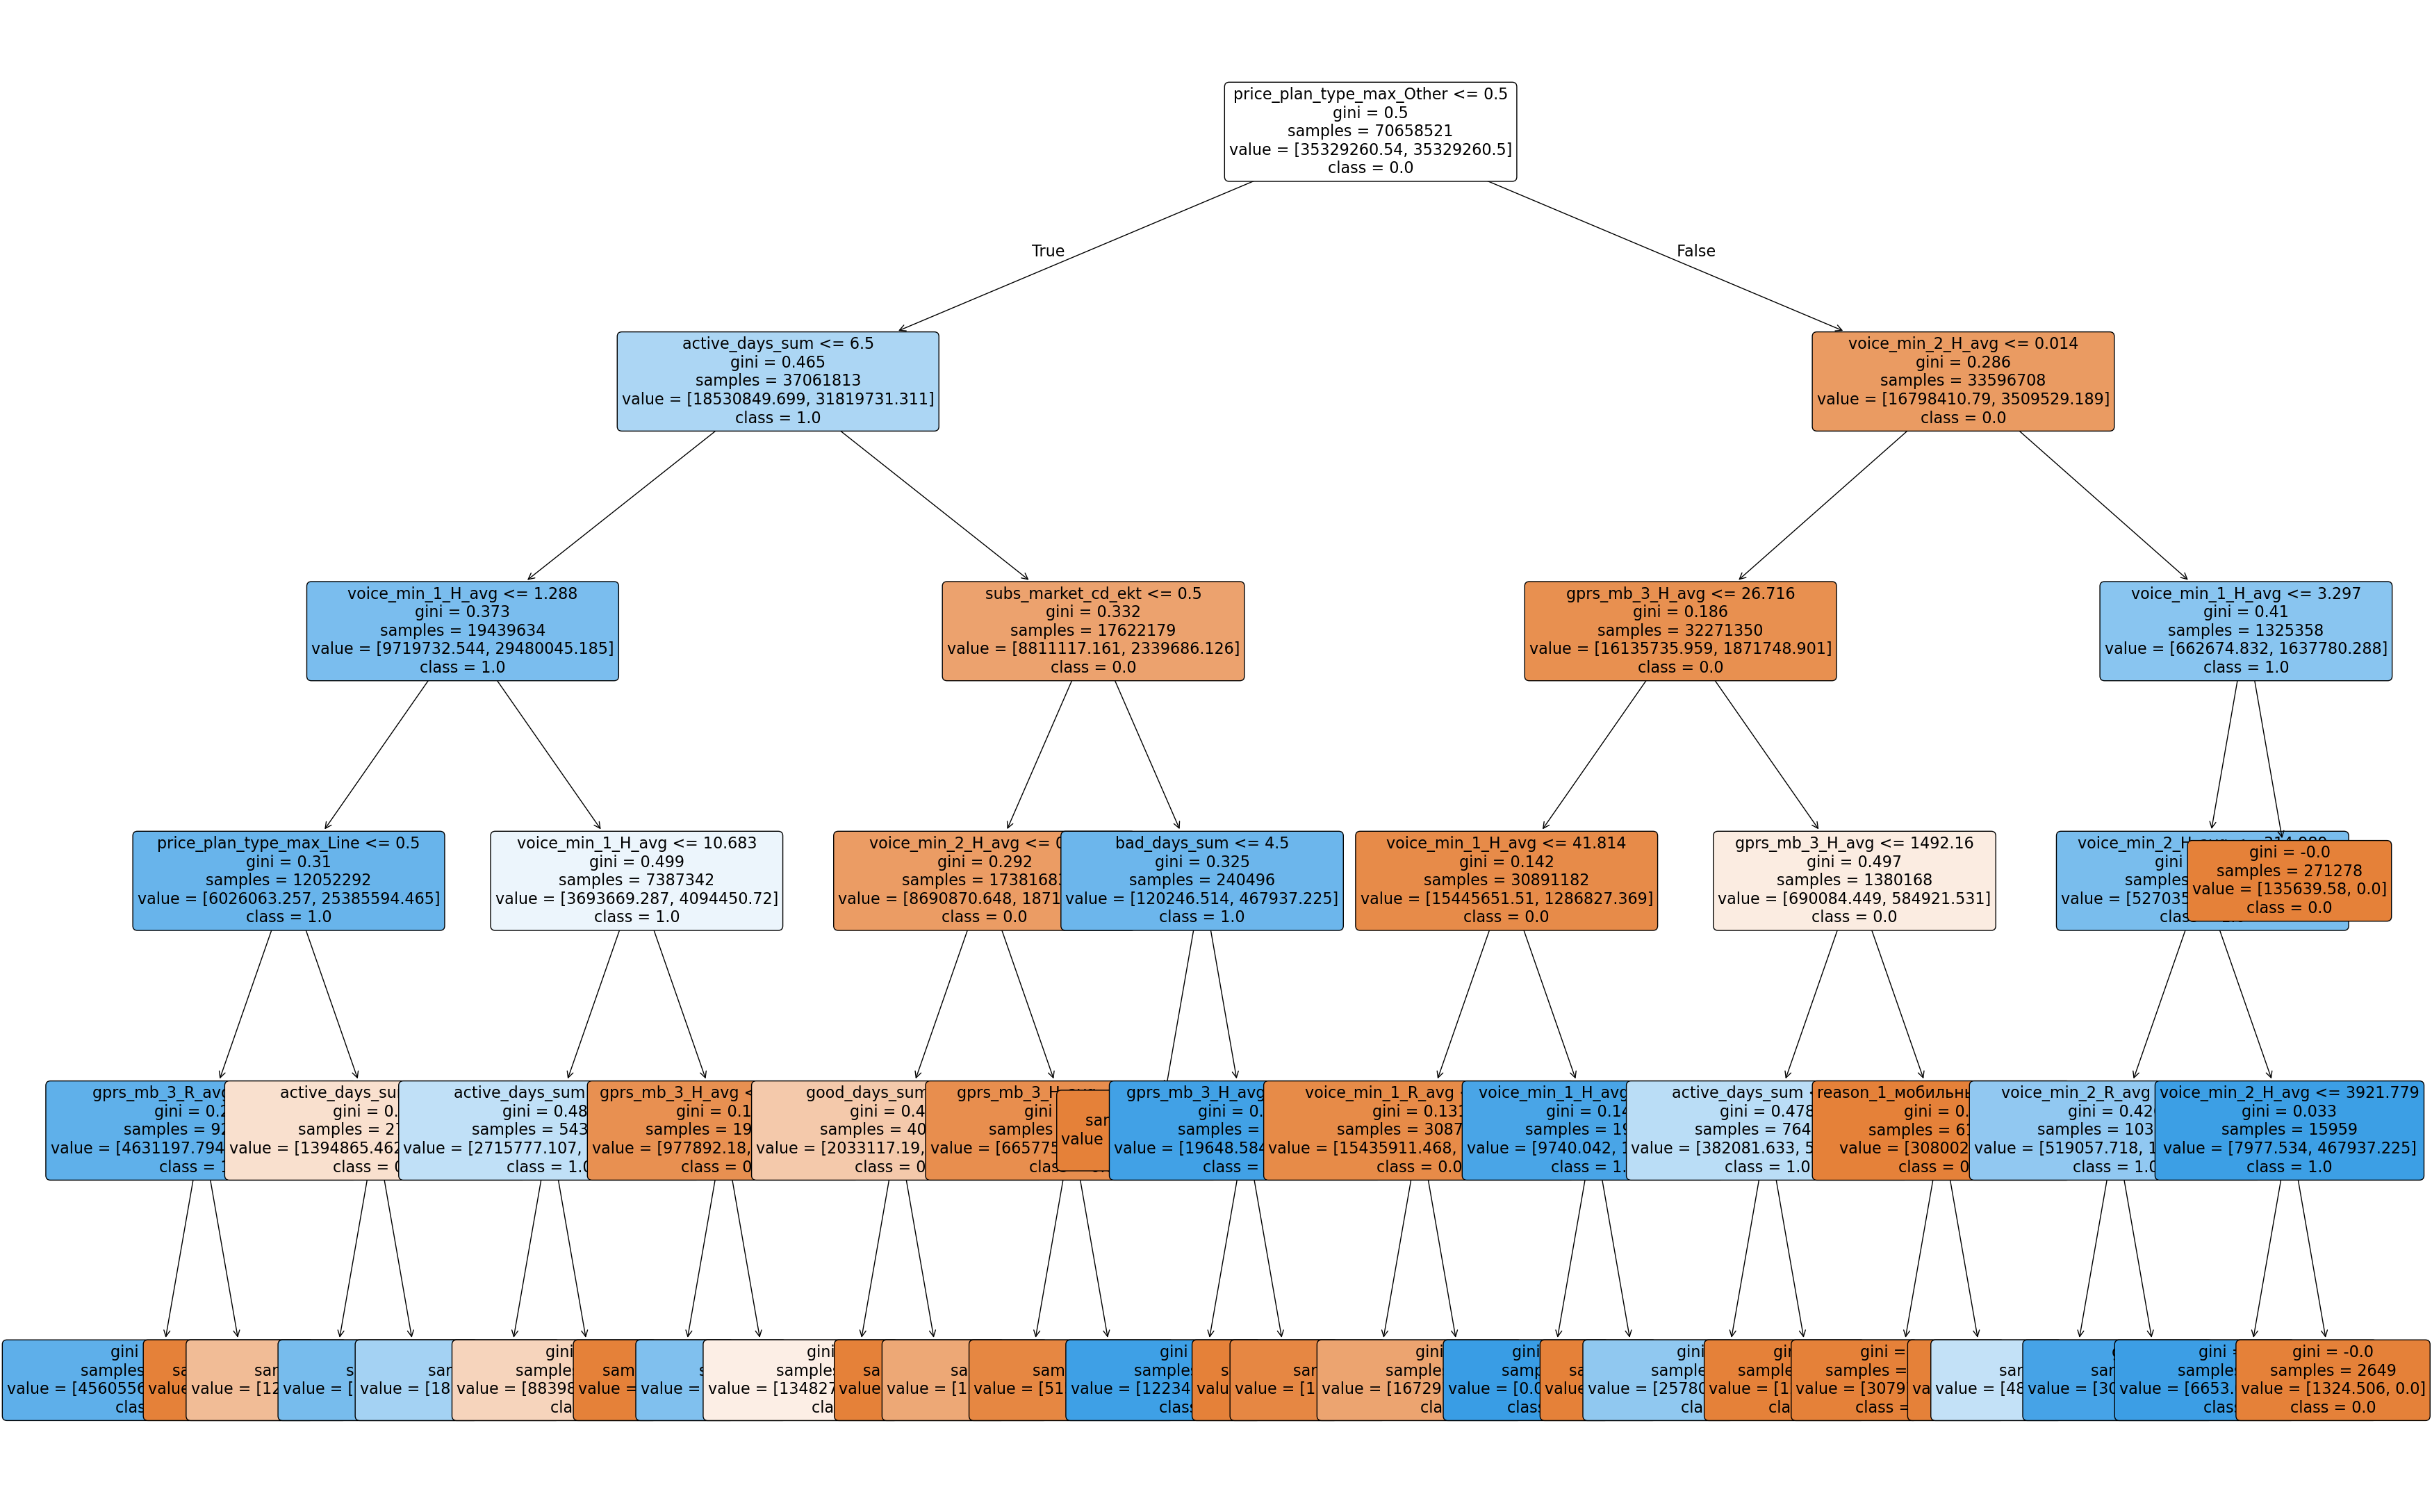

In [61]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize = (42, 28)) # Adjust figure size as needed
tree.plot_tree(dtree,
               feature_names = features,
               class_names = [str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, # For classifiers
               filled = True,
               rounded = True,
               fontsize = 16,
               proportion = False,
               # centered
              )
plt.show()

In [62]:
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

# Настроим Graphviz для отрисовки дерева
dot_data = tree.export_graphviz(dtree, 
                                out_file=None, 
                                feature_names=features,  
                                class_names=[str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, 
                                filled=True, 
                                rounded=True)

# Рисуем дерево
graph = graphviz.Source(dot_data)
graph.render("tree_visualization", view = True)  # Сохраняет и открывает изображение

'tree_visualization.pdf'

xdg-open: no method available for opening 'tree_visualization.pdf'


In [47]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)

In [48]:
tree_to_code(dtree, features)

def tree(voice_min_1_H_avg, voice_min_2_H_avg, voice_min_1_R_avg, voice_min_2_R_avg, gprs_mb_3_H_avg, gprs_mb_3_R_avg, calls_sum, dialog_time_sum, req_qnt_sum, active_days_sum, bad_days_sum, accept_days_sum, good_days_sum, repr2q2025_max, price_plan_type_max_Bundle, price_plan_type_max_Data, price_plan_type_max_Line, price_plan_type_max_Other, subs_market_cd_ekt, subs_market_cd_kzn, subs_market_cd_spb, subs_market_cd_ufa, subs_market_cd_vip, reason_1_интернет, reason_1_качество, reason_1_мобильный, reason_1_офсет, reason_1_связи, reason_2_интернет, reason_2_не, reason_2_обращение, reason_2_после, reason_2_работает, reason_3_консультация, reason_3_настройки, reason_3_сети, reason_3_сохранен, reason_3_устройства):
  if price_plan_type_max_Other <= 0.5:
    if active_days_sum <= 6.5:
      if voice_min_1_H_avg <= 1.2880953550338745:
        if price_plan_type_max_Line <= 0.5:
          if gprs_mb_3_R_avg <= 0.006669998401775956:
            return 1
          else:  # if gprs_mb_3_R_avg >

In [ ]:
# ****************************************************************************************************************************************************************************

In [67]:
dtree_7 = DecisionTreeClassifier(max_depth = 7, class_weight = 'balanced',  max_leaf_nodes = 20)
dtree_7.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=7, max_leaf_nodes=20)

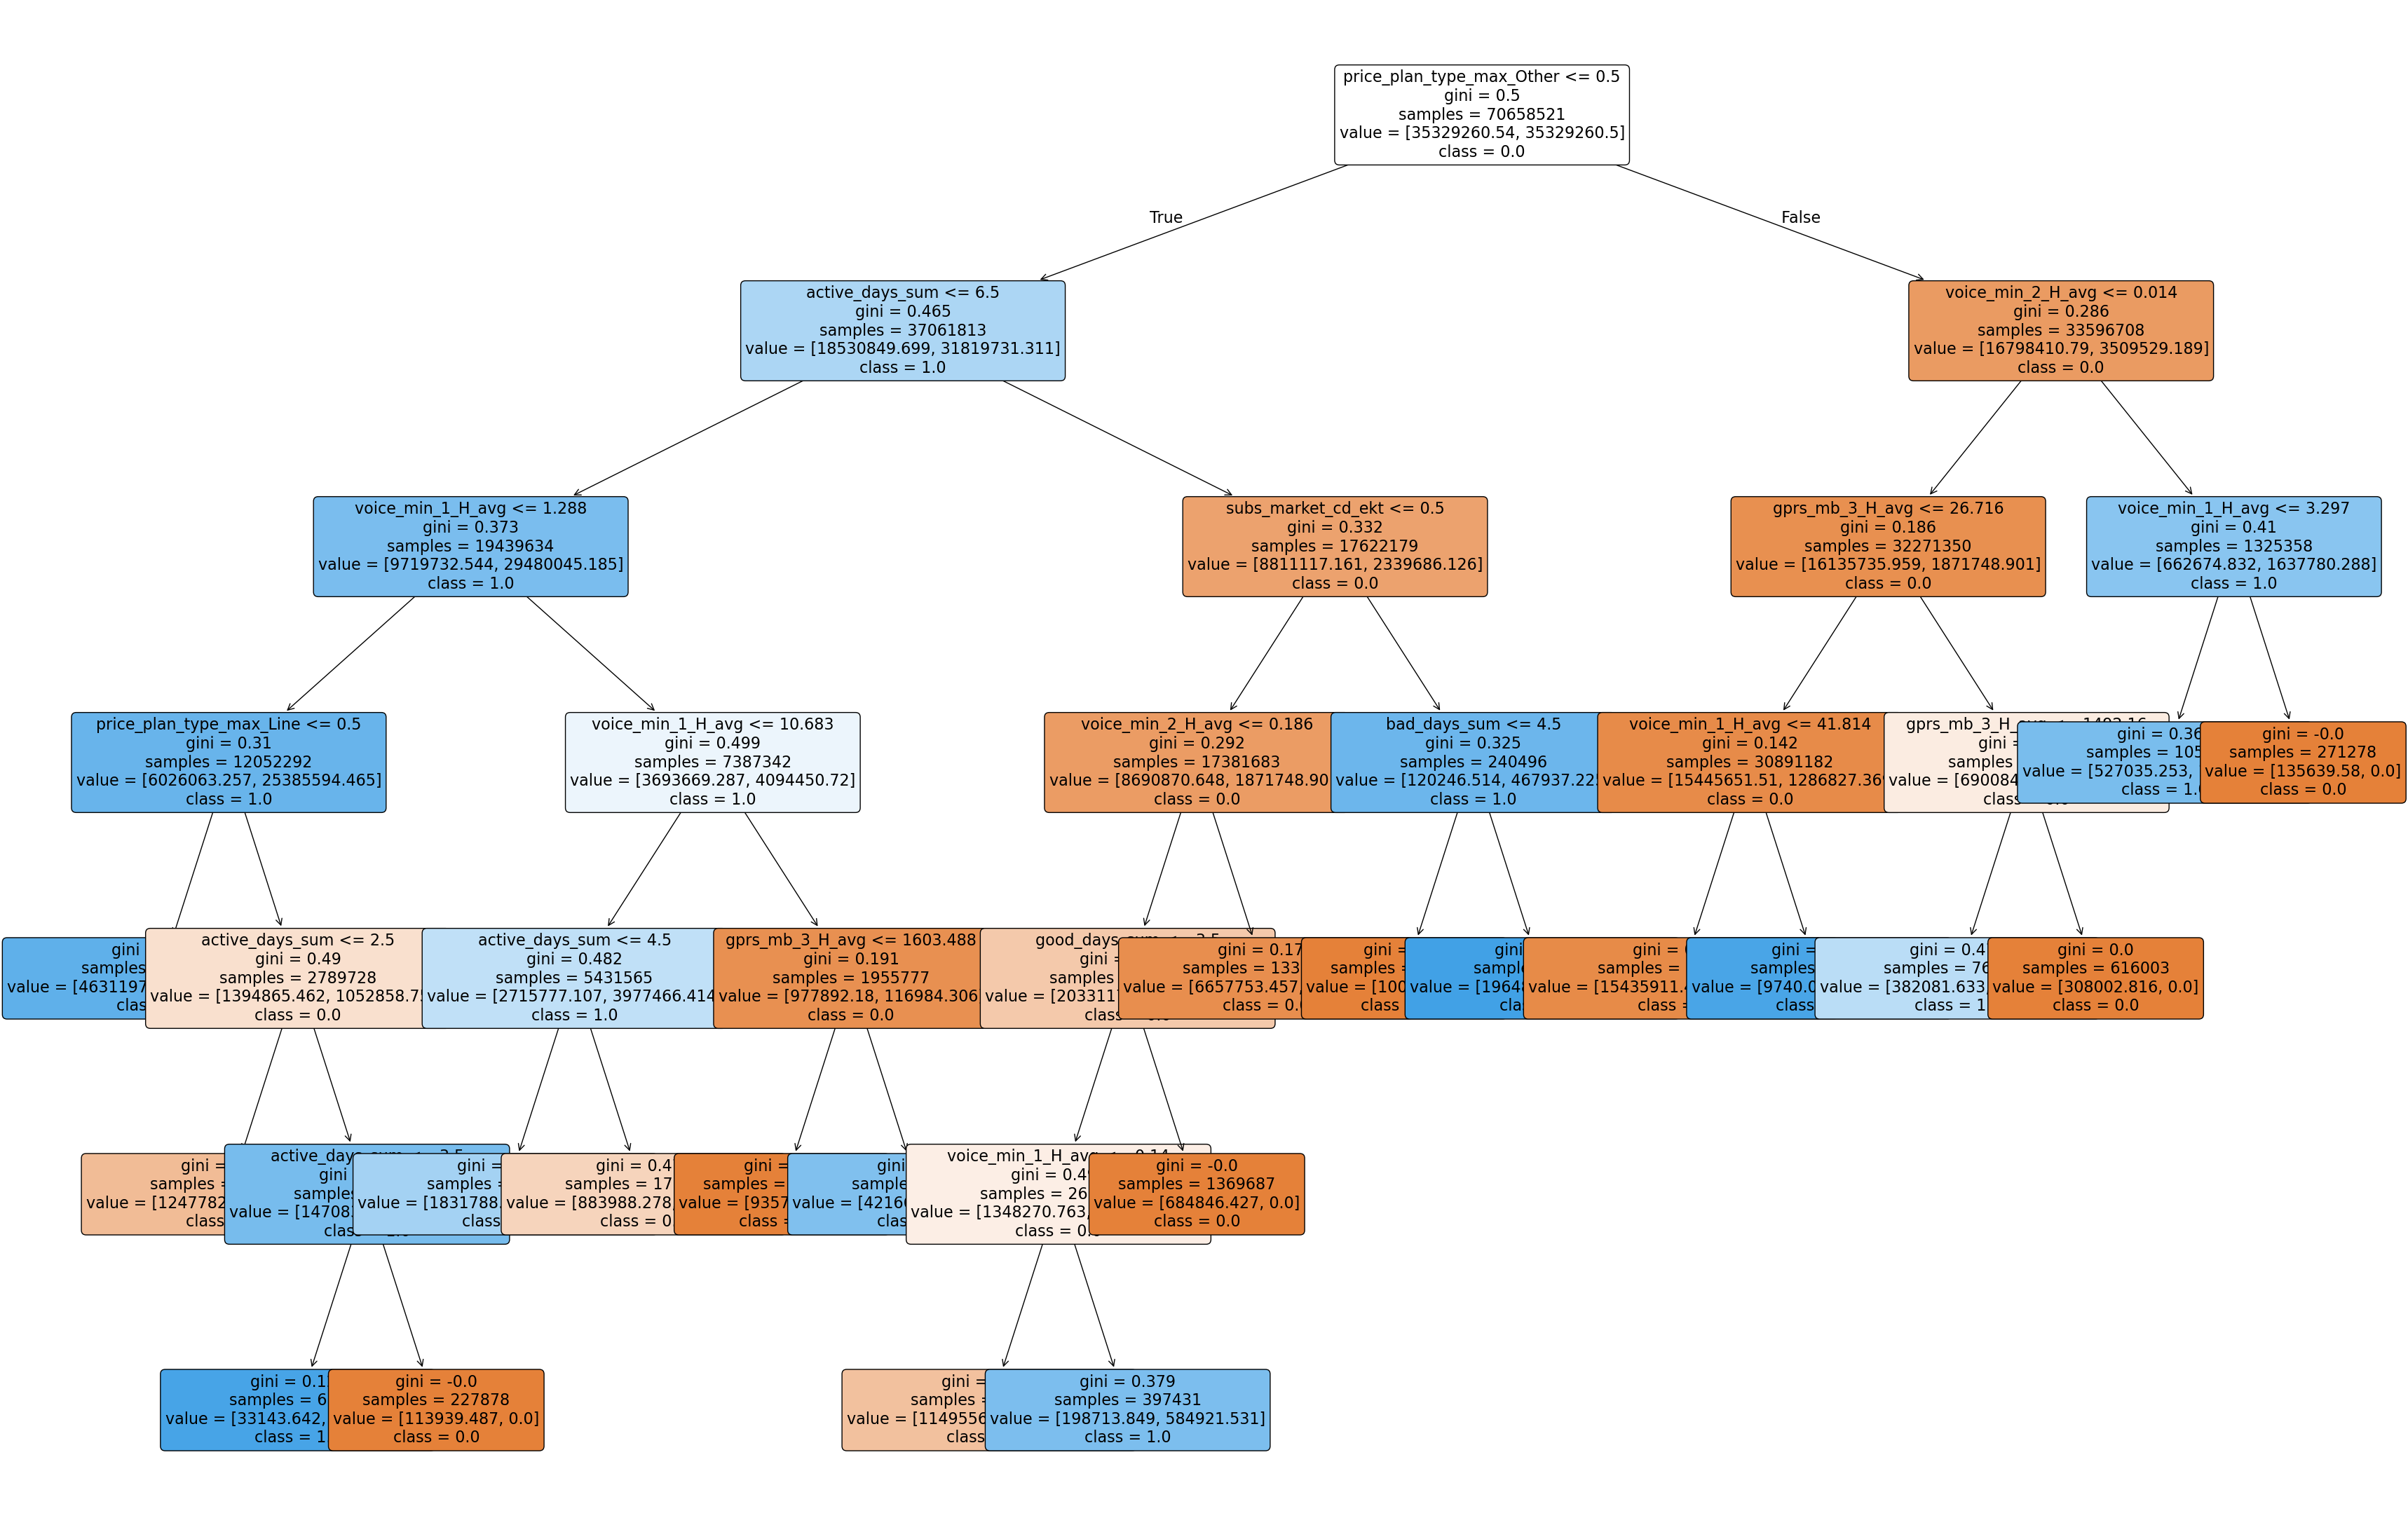

In [68]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize = (42, 28)) # Adjust figure size as needed
tree.plot_tree(dtree_7,
               feature_names = features,
               class_names = [str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, # For classifiers
               filled = True,
               rounded = True,
               fontsize = 16,
               proportion = False,
               # centered
              )
plt.show()

In [69]:
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

# Настроим Graphviz для отрисовки дерева
dot_data = tree.export_graphviz(dtree_7, 
                                out_file=None, 
                                feature_names=features,  
                                class_names=[str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, 
                                filled=True, 
                                rounded=True)

# Рисуем дерево
graph = graphviz.Source(dot_data)
graph.render("tree_max_depth_7_max_leaf_20", view = True)  # Сохраняет и открывает изображение

'tree_max_depth_7_max_leaf_20.pdf'

xdg-open: no method available for opening 'tree_max_depth_7_max_leaf_20.pdf'


In [70]:
tree_to_code(dtree_7, features)

def tree(voice_min_1_H_avg, voice_min_2_H_avg, voice_min_1_R_avg, voice_min_2_R_avg, gprs_mb_3_H_avg, gprs_mb_3_R_avg, calls_sum, dialog_time_sum, req_qnt_sum, active_days_sum, bad_days_sum, accept_days_sum, good_days_sum, repr2q2025_max, price_plan_type_max_Bundle, price_plan_type_max_Data, price_plan_type_max_Line, price_plan_type_max_Other, subs_market_cd_ekt, subs_market_cd_kzn, subs_market_cd_spb, subs_market_cd_ufa, subs_market_cd_vip, reason_1_интернет, reason_1_качество, reason_1_мобильный, reason_1_офсет, reason_1_связи, reason_2_интернет, reason_2_не, reason_2_обращение, reason_2_после, reason_2_работает, reason_3_консультация, reason_3_настройки, reason_3_сети, reason_3_сохранен, reason_3_устройства):
  if price_plan_type_max_Other <= 0.5:
    if active_days_sum <= 6.5:
      if voice_min_1_H_avg <= 1.2880953550338745:
        if price_plan_type_max_Line <= 0.5:
          return 1
        else:  # if price_plan_type_max_Line > 0.5
          if active_days_sum <= 2.5:
       

In [ ]:
# ****************************************************************************************************************************************************************************

In [63]:
# dtree = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 15, class_weight = 'balanced') # Example: limit depth for easier visualization

dtree_10 = DecisionTreeClassifier(max_depth = 10, class_weight = 'balanced')
dtree_10.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=10)

xdg-open: no method available for opening 'tree_visualization_max_depth_10.pdf'


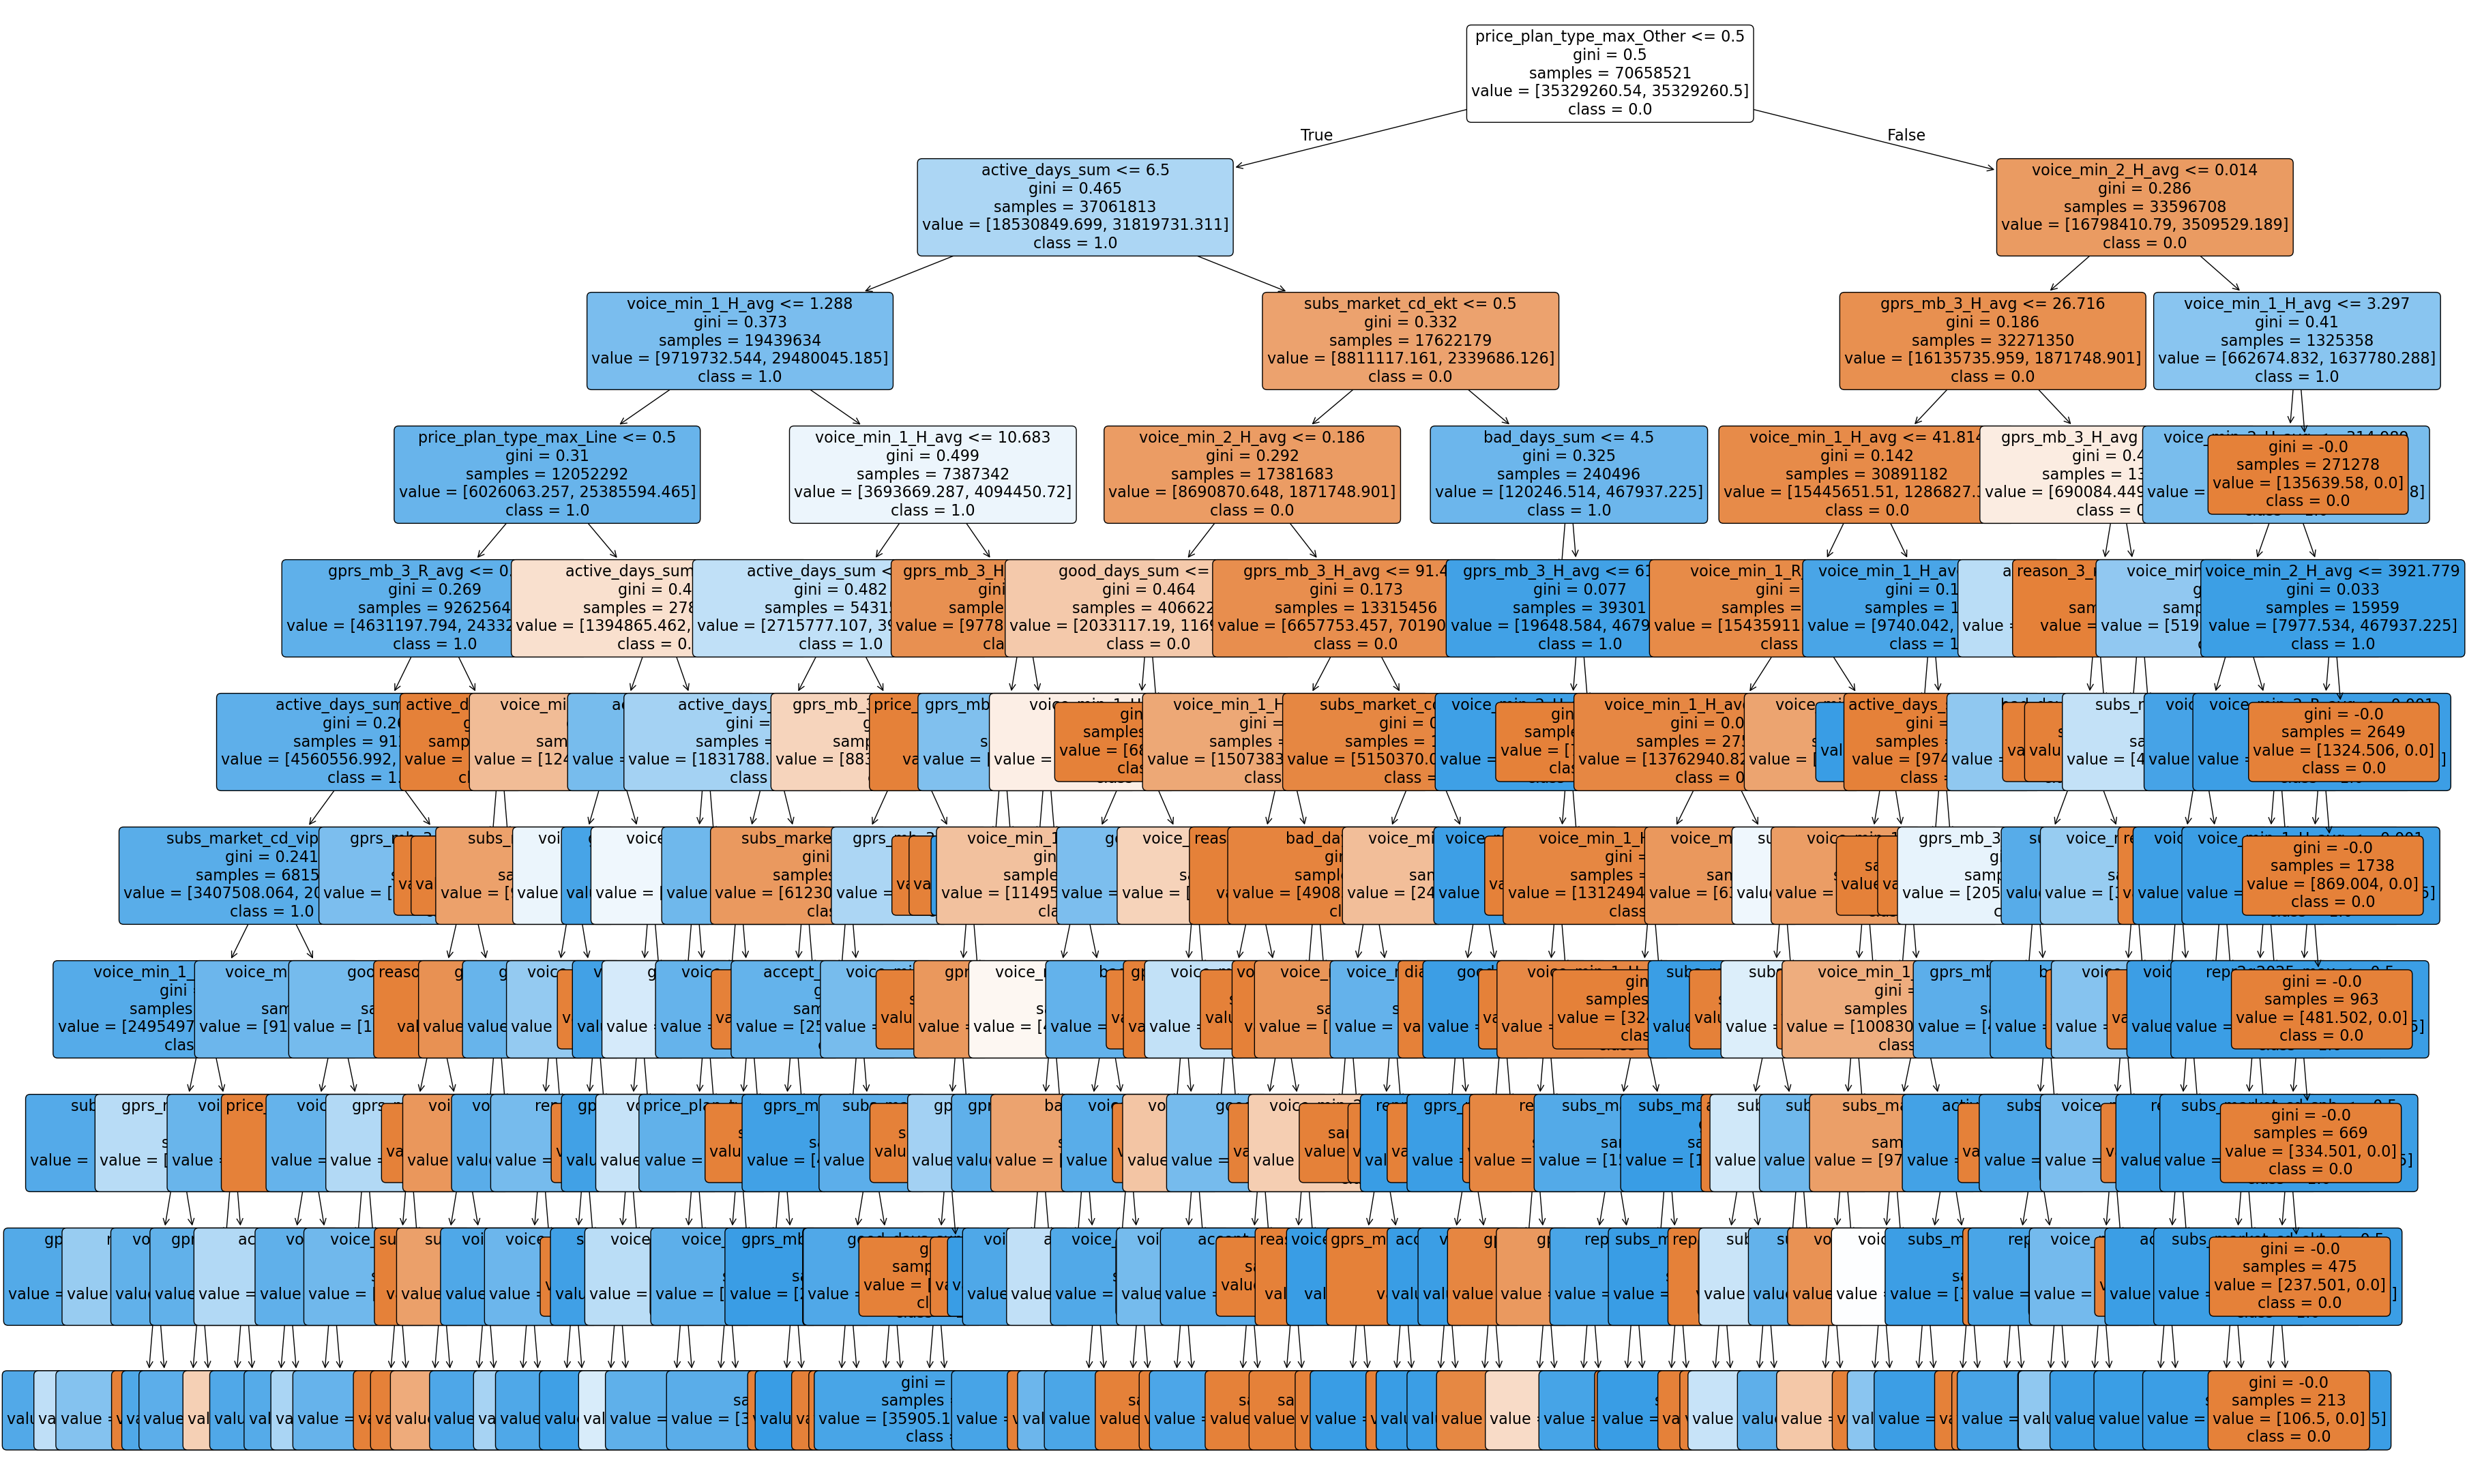

In [65]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize = (42, 28)) # Adjust figure size as needed
tree.plot_tree(dtree_10,
               feature_names = features,
               class_names = [str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, # For classifiers
               filled = True,
               rounded = True,
               fontsize = 16,
               proportion = False,
               # centered
              )
plt.show()

In [66]:
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

# Настроим Graphviz для отрисовки дерева
dot_data = tree.export_graphviz(dtree_10, 
                                out_file=None, 
                                feature_names=features,  
                                class_names=[str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, 
                                filled=True, 
                                rounded=True)

# Рисуем дерево
graph = graphviz.Source(dot_data)
graph.render("tree_visualization_max_depth_10", view = True)  # Сохраняет и открывает изображение

'tree_visualization_max_depth_10.pdf'

xdg-open: no method available for opening 'tree_visualization_max_depth_10.pdf'


In [46]:
# ****************************************************************************************************************************************************************************

In [44]:
dtree_2 = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced',  max_leaf_nodes = 12)
dtree_2.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_leaf_nodes=12)

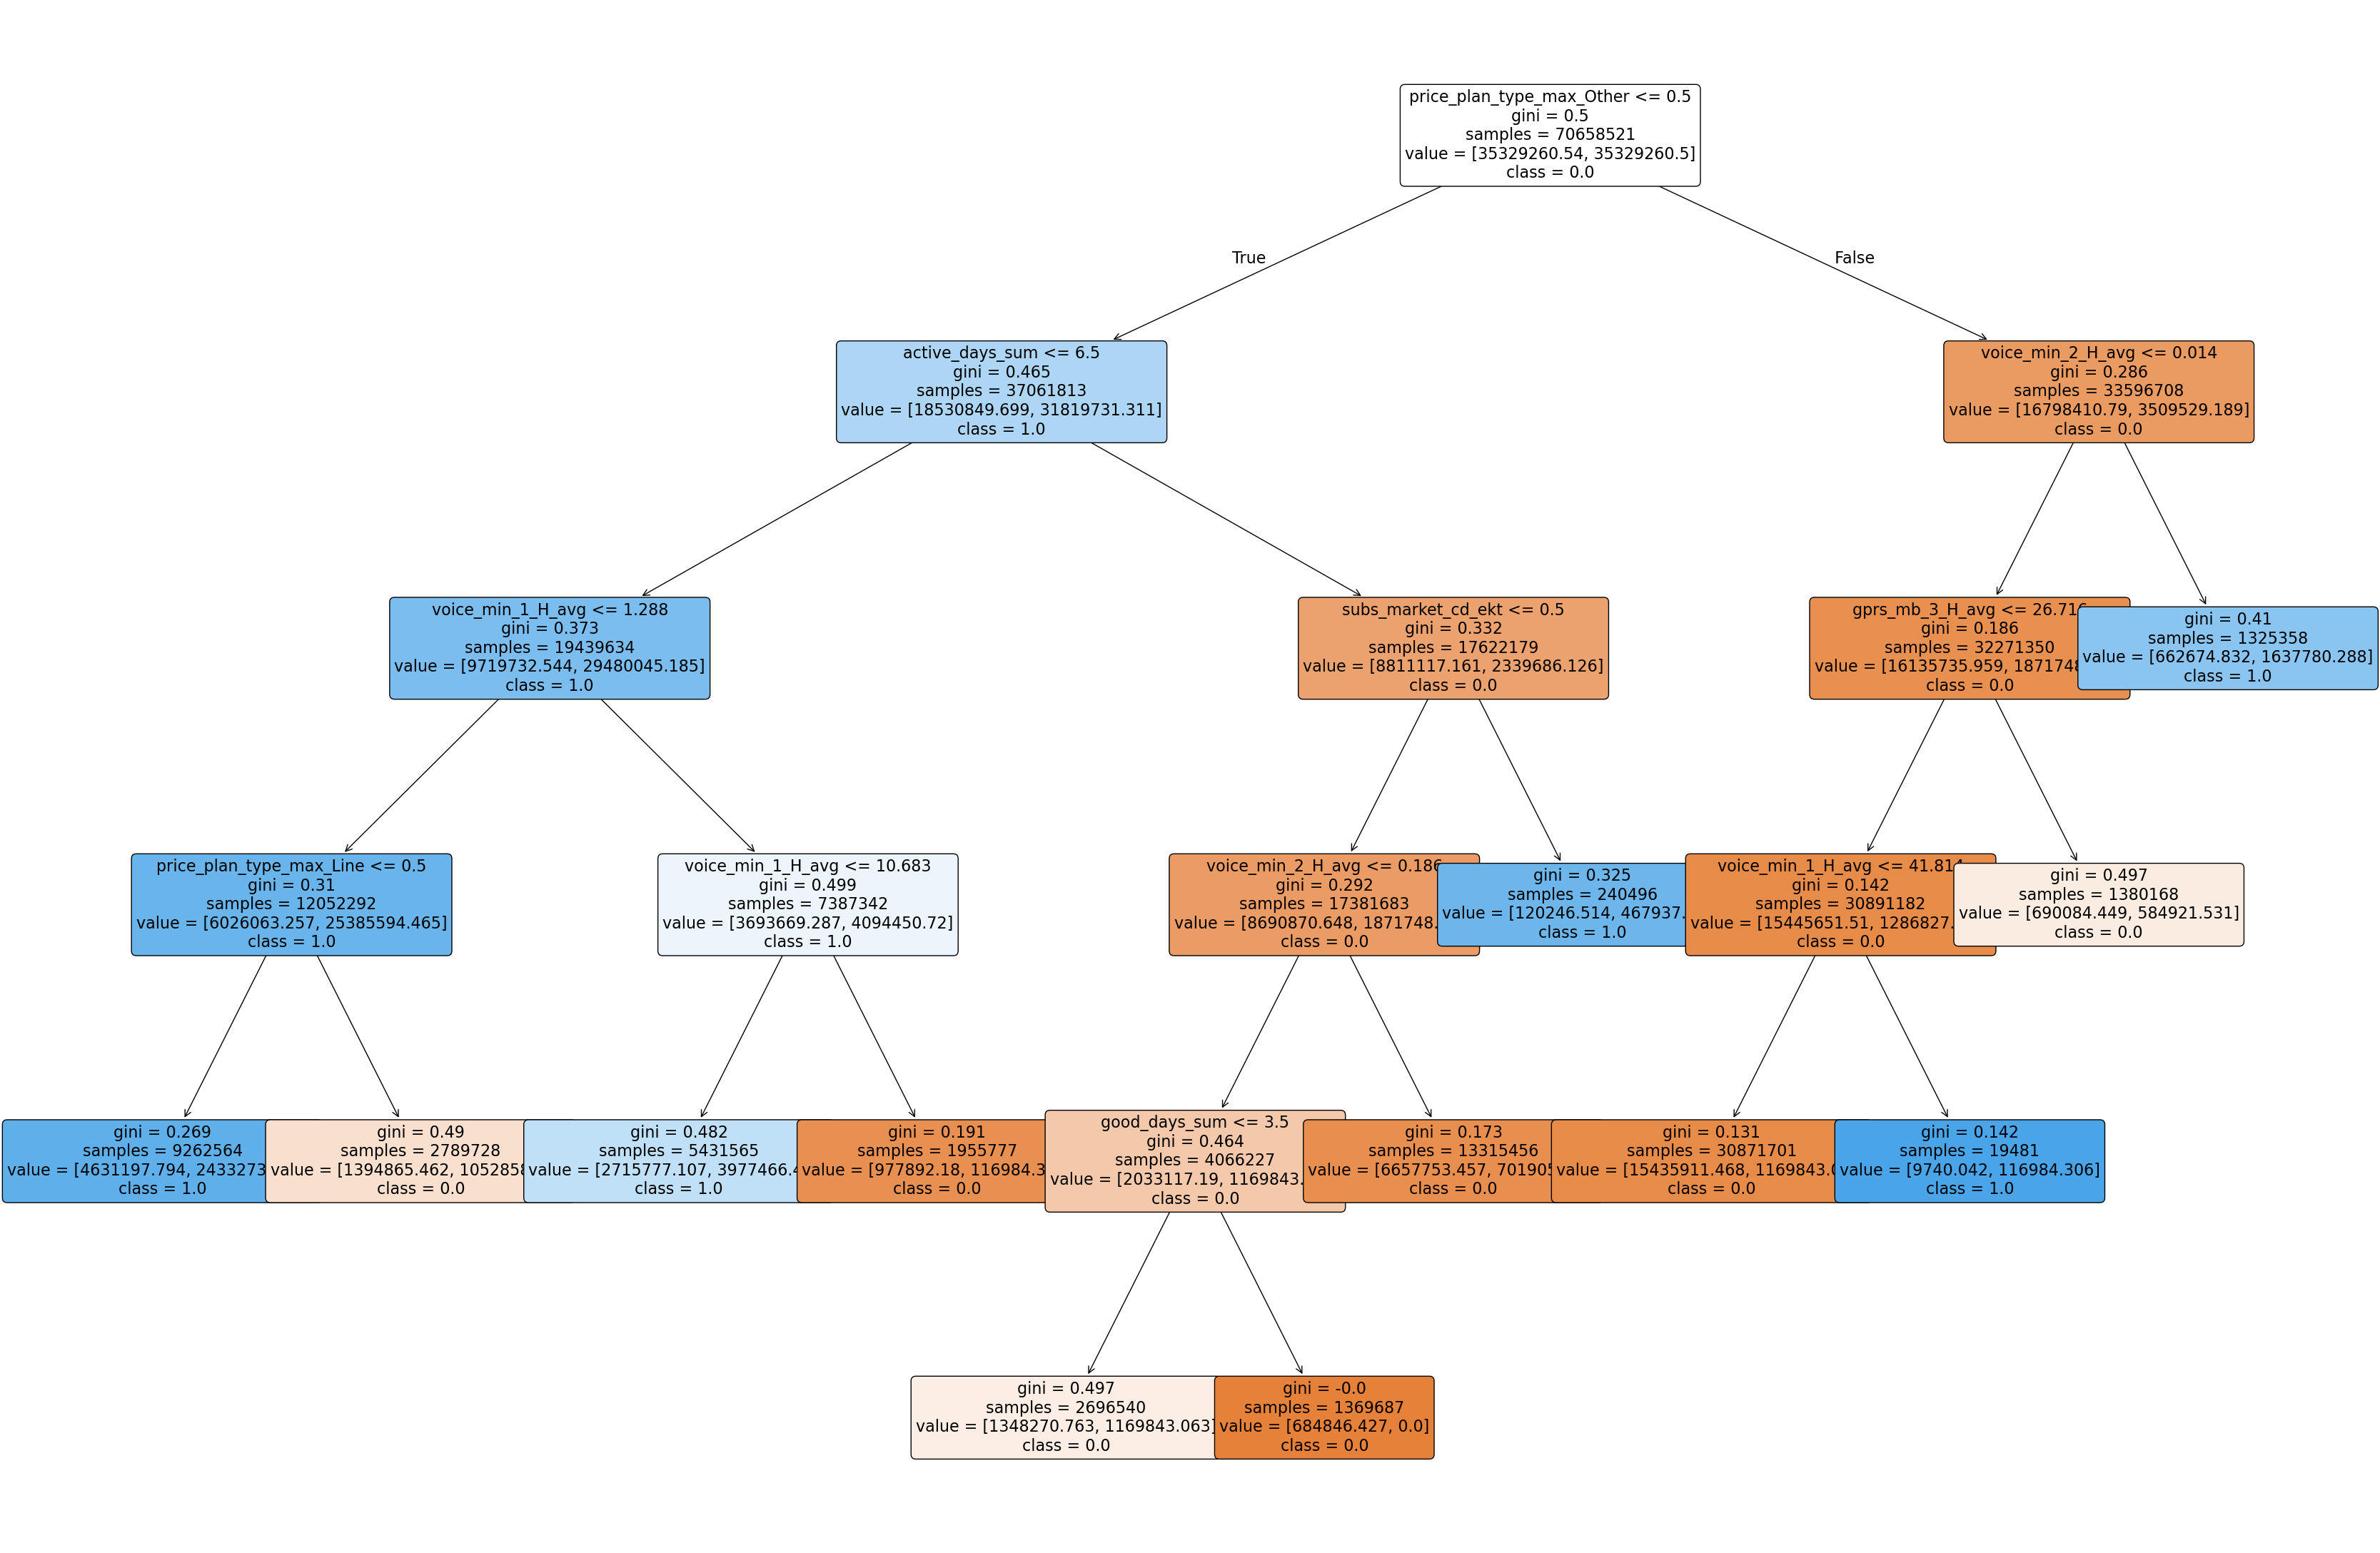

In [45]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize = (42, 28)) # Adjust figure size as needed
tree.plot_tree(dtree_2,
               feature_names = features,
               class_names = [str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, # For classifiers
               filled = True,
               rounded = True,
               fontsize = 16)
plt.show()

In [49]:
tree_to_code(dtree_2, features)

def tree(voice_min_1_H_avg, voice_min_2_H_avg, voice_min_1_R_avg, voice_min_2_R_avg, gprs_mb_3_H_avg, gprs_mb_3_R_avg, calls_sum, dialog_time_sum, req_qnt_sum, active_days_sum, bad_days_sum, accept_days_sum, good_days_sum, repr2q2025_max, price_plan_type_max_Bundle, price_plan_type_max_Data, price_plan_type_max_Line, price_plan_type_max_Other, subs_market_cd_ekt, subs_market_cd_kzn, subs_market_cd_spb, subs_market_cd_ufa, subs_market_cd_vip, reason_1_интернет, reason_1_качество, reason_1_мобильный, reason_1_офсет, reason_1_связи, reason_2_интернет, reason_2_не, reason_2_обращение, reason_2_после, reason_2_работает, reason_3_консультация, reason_3_настройки, reason_3_сети, reason_3_сохранен, reason_3_устройства):
  if price_plan_type_max_Other <= 0.5:
    if active_days_sum <= 6.5:
      if voice_min_1_H_avg <= 1.2880953550338745:
        if price_plan_type_max_Line <= 0.5:
          return 1
        else:  # if price_plan_type_max_Line > 0.5
          return 0
      else:  # if voice_m

In [50]:
# ****************************************************************************************************************************************************************************

In [51]:
dtree_3 = DecisionTreeClassifier(max_depth = 10, class_weight = 'balanced',  max_leaf_nodes = 10)
dtree_3.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=10)

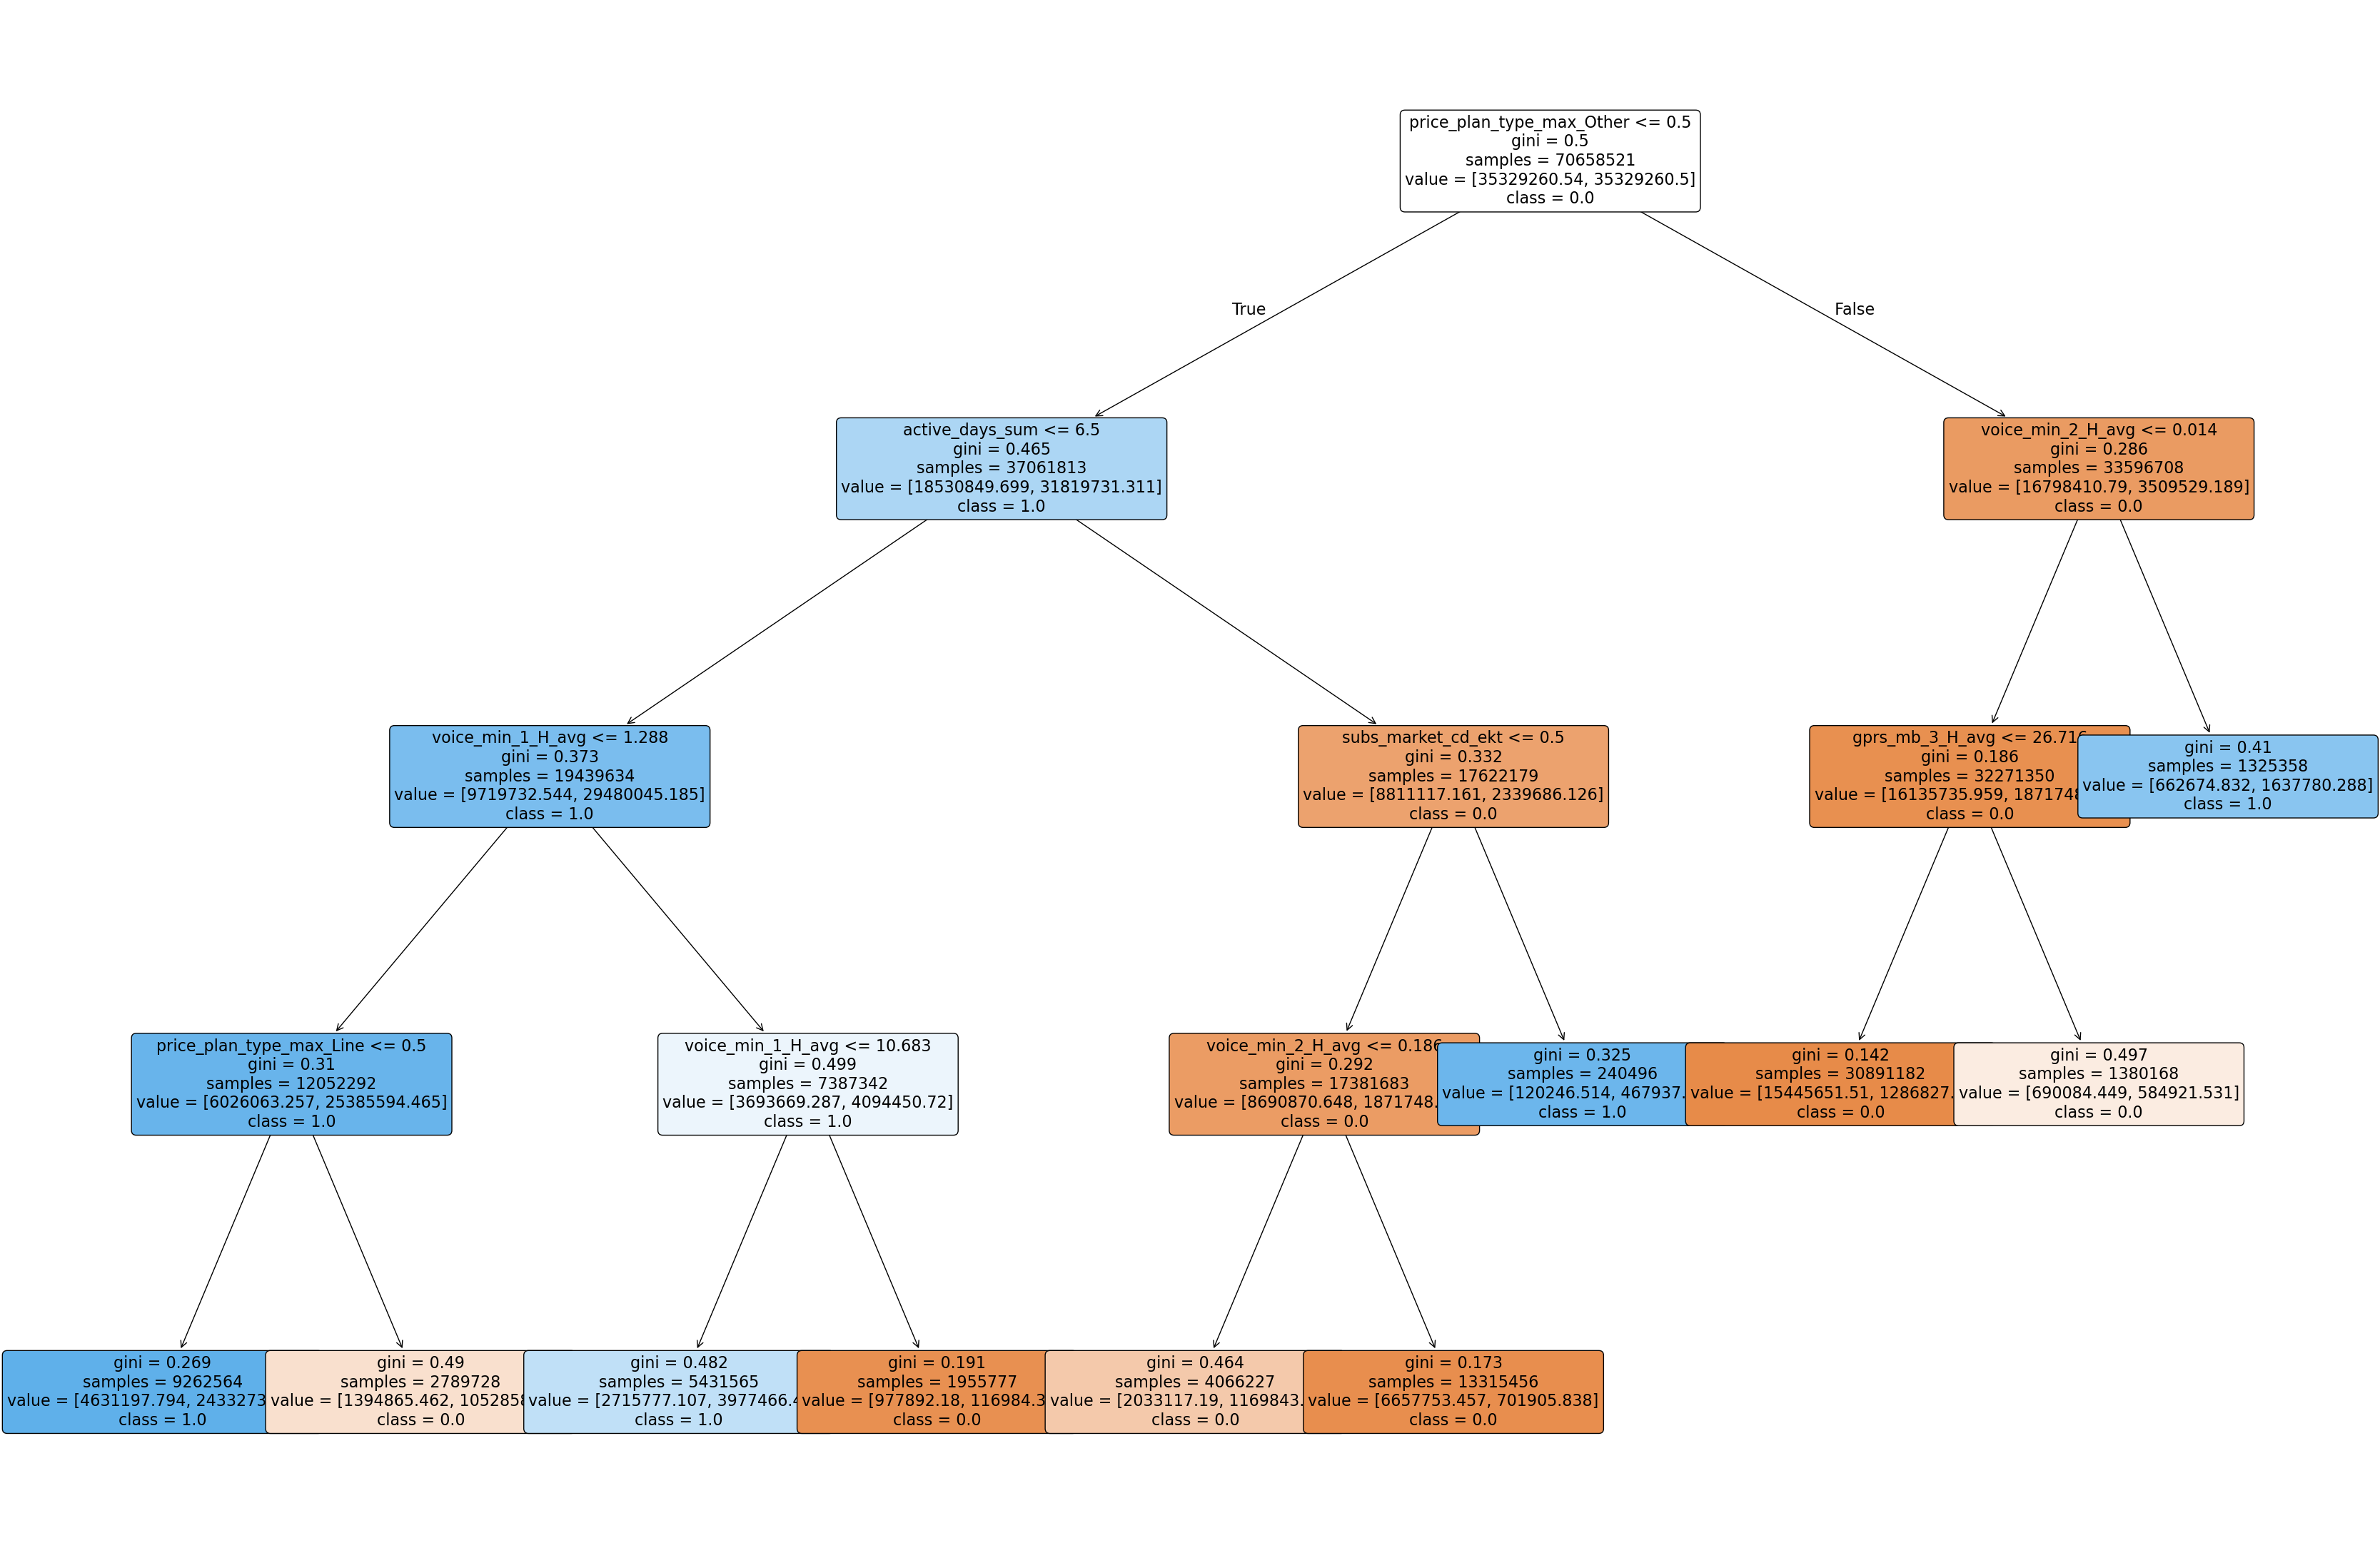

In [52]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize = (42, 28)) # Adjust figure size as needed
tree.plot_tree(dtree_3,
               feature_names = features,
               class_names = [str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, # For classifiers
               filled = True,
               rounded = True,
               fontsize = 16)
plt.show()

In [72]:
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

# Настроим Graphviz для отрисовки дерева
dot_data = tree.export_graphviz(dtree_3, 
                                out_file=None, 
                                feature_names=features,  
                                class_names=[str(c) for c in dtree.classes_] if hasattr(dtree, 'classes_') else None, 
                                filled=True, 
                                rounded=True)

# Рисуем дерево
graph = graphviz.Source(dot_data)
graph.render("tree_visualization_max_leaf_nodes_10", view = True)  # Сохраняет и открывает изображение

'tree_visualization_max_leaf_nodes_10.pdf'

xdg-open: no method available for opening 'tree_visualization_max_leaf_nodes_10.pdf'


In [73]:
tree_to_code(dtree_3, features)

def tree(voice_min_1_H_avg, voice_min_2_H_avg, voice_min_1_R_avg, voice_min_2_R_avg, gprs_mb_3_H_avg, gprs_mb_3_R_avg, calls_sum, dialog_time_sum, req_qnt_sum, active_days_sum, bad_days_sum, accept_days_sum, good_days_sum, repr2q2025_max, price_plan_type_max_Bundle, price_plan_type_max_Data, price_plan_type_max_Line, price_plan_type_max_Other, subs_market_cd_ekt, subs_market_cd_kzn, subs_market_cd_spb, subs_market_cd_ufa, subs_market_cd_vip, reason_1_интернет, reason_1_качество, reason_1_мобильный, reason_1_офсет, reason_1_связи, reason_2_интернет, reason_2_не, reason_2_обращение, reason_2_после, reason_2_работает, reason_3_консультация, reason_3_настройки, reason_3_сети, reason_3_сохранен, reason_3_устройства):
  if price_plan_type_max_Other <= 0.5:
    if active_days_sum <= 6.5:
      if voice_min_1_H_avg <= 1.2880953550338745:
        if price_plan_type_max_Line <= 0.5:
          return 1
        else:  # if price_plan_type_max_Line > 0.5
          return 0
      else:  # if voice_m

In [54]:
# ****************************************************************************************************************************************************************************